# Data Loading

In [610]:
# Import all dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np

from sklearn import metrics
from sklearn.metrics import recall_score, make_scorer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.feature_selection import SelectPercentile, chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Import the data set
df = pd.read_csv('../data/H1.csv')

df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [611]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40060 entries, 0 to 40059
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   40060 non-null  int64  
 1   LeadTime                     40060 non-null  int64  
 2   ArrivalDateYear              40060 non-null  int64  
 3   ArrivalDateMonth             40060 non-null  object 
 4   ArrivalDateWeekNumber        40060 non-null  int64  
 5   ArrivalDateDayOfMonth        40060 non-null  int64  
 6   StaysInWeekendNights         40060 non-null  int64  
 7   StaysInWeekNights            40060 non-null  int64  
 8   Adults                       40060 non-null  int64  
 9   Children                     40060 non-null  int64  
 10  Babies                       40060 non-null  int64  
 11  Meal                         40060 non-null  object 
 12  Country                      39596 non-null  object 
 13  MarketSegment   

# Data Analysis


## Exploration

I will start with an automated EDAs using pandas-profiling and ydata-profiling. I will then do some manual EDA to answer the questions above.

In [612]:
# UNCOMMENT THE FOLLOWING LINES TO RUN THE REPORT AGAIN
# from ydata_profiling import ProfileReport
# 
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_file("ydata_report.html")

<AxesSubplot: >

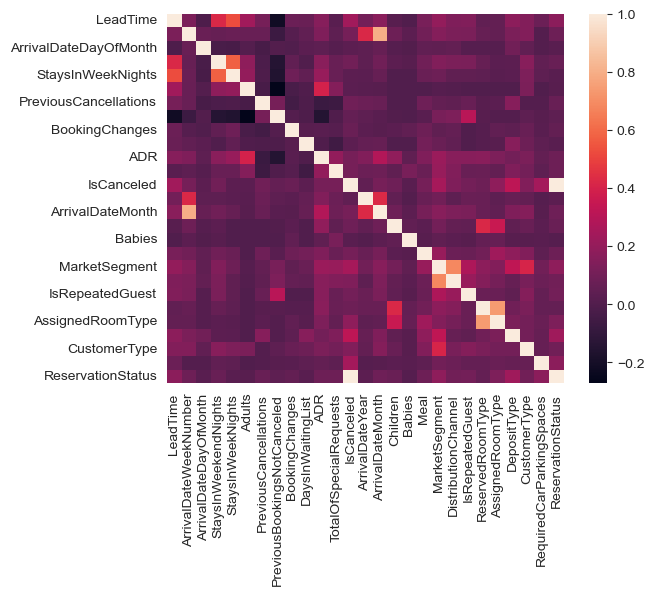

In [613]:
# Correlations were extracted from the report generated by y-data-profiling, it's pretty neat because it uses the 
# best correlation technique depending on the column types and handles categorical values.
corr_df = pd.read_csv('correlations.csv', index_col=[0])
corr_df.head()
sns.heatmap(corr_df)

In [614]:
# Checkout the top positive correlations, only those over 0.3. 
corr_df = corr_df[corr_df < 1]
best_positive = corr_df[(corr_df >= 0.3)].unstack().sort_values()
best_positive.head(20)

IsRepeatedGuest              PreviousBookingsNotCanceled    0.309
PreviousBookingsNotCanceled  IsRepeatedGuest                0.309
DepositType                  IsCanceled                     0.323
IsCanceled                   DepositType                    0.323
MarketSegment                DepositType                    0.326
DepositType                  MarketSegment                  0.326
AssignedRoomType             Children                       0.357
Children                     AssignedRoomType               0.357
Adults                       ADR                            0.395
ADR                          Adults                         0.395
CustomerType                 MarketSegment                  0.406
MarketSegment                CustomerType                   0.406
ReservedRoomType             Children                       0.420
Children                     ReservedRoomType               0.420
LeadTime                     StaysInWeekendNights           0.421
ArrivalDat

## Questions

Let's start by trying to answer the following questions:

1. What are our guest demographics, and how do they affect the booking cancellation?
2. What is the cost of booking per night, and how does it vary over time?
3. Which are the busiest months?
4. Is LeadTime a good predictor of cancellations?
5. Which market segments are the most important ones?

### What are our guest demographics, and how do they affect the booking cancellation?

<AxesSubplot: xlabel='Babies', ylabel='count'>

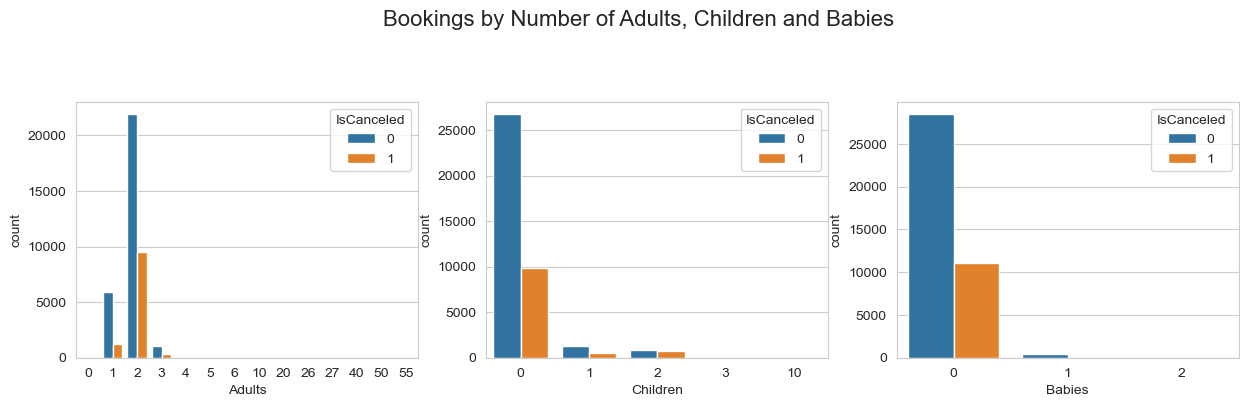

In [615]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Bookings by Number of Adults, Children and Babies', fontsize=16)
plt.subplots_adjust(top=0.75)

sns.countplot(x='Adults', hue='IsCanceled', data=df, ax=ax[0])
sns.countplot(x='Children', hue='IsCanceled', data=df, ax=ax[1])
sns.countplot(x='Babies', hue='IsCanceled', data=df, ax=ax[2])

<AxesSubplot: title={'center': 'Top 10 Countries with Cancelations'}, ylabel='Country'>

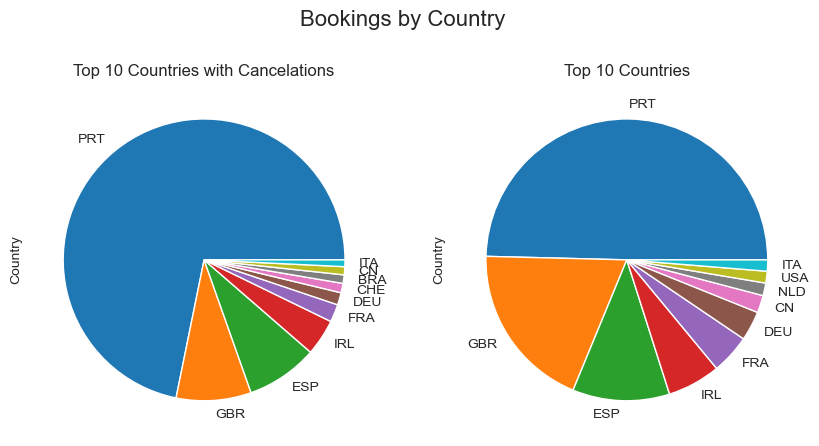

In [616]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
fig.suptitle('Bookings by Country', fontsize=16)
plt.subplots_adjust(top=0.85)
df['Country'].value_counts().head(10).plot(kind='pie', figsize=(10, 5), title='Top 10 Countries', ax=ax[1])
df[df['IsCanceled'] == 1]['Country'].value_counts().head(10).plot(kind='pie', figsize=(10, 5), title='Top 10 Countries with Cancelations', ax=ax[0])

#### Insights
* From what we can see, bookings that include children are less likely to be cancelled.
* Most of the customers of this hotel are couples with no children. Of these, roughly half of the bookings are cancelled.
* Single adults are less likely to cancel their bookings.
* Most of the bookings are from Portugal, followed by the UK and Spain. However, bookings from Portuguese customers are more likely to be cancelled. 

### What is the cost of booking per night, and how does it vary over time?

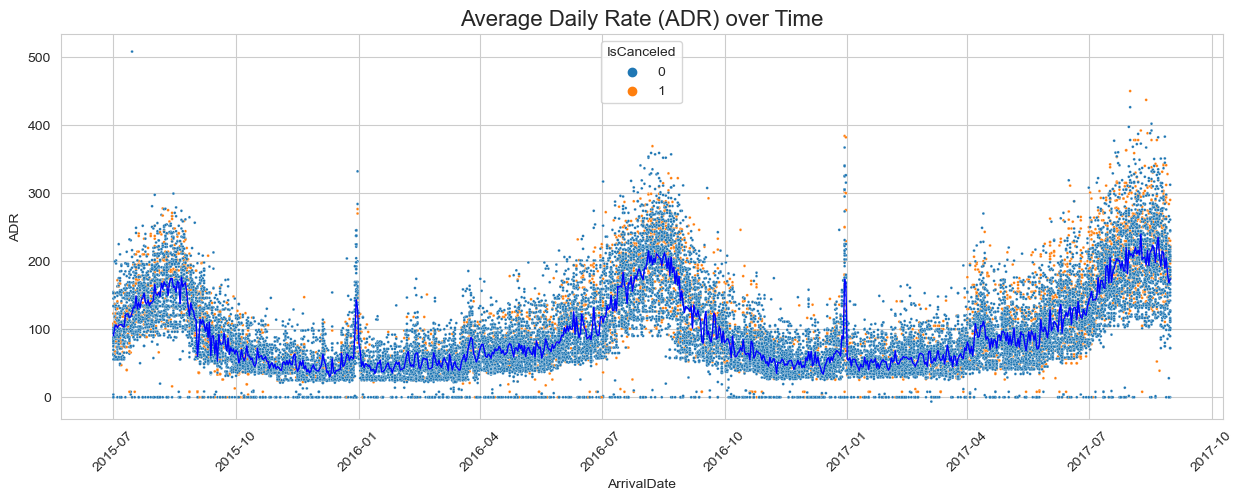

In [617]:
# Create a new column with the arrival date.
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDateYear'].astype(str) + '-' +
                                   df['ArrivalDateMonth'] + '-' +
                                   df['ArrivalDateDayOfMonth'].astype(str))

# Creating the 'BookingDate' column by subtracting 'LeadTime' days from 'ArrivalDate'
df['BookingDate'] = df['ArrivalDate'] - pd.to_timedelta(df['LeadTime'], unit='d')
 
plt.figure(figsize=(15, 5))
sns.scatterplot(x='ArrivalDate', y='ADR', hue='IsCanceled', data=df, s=4)
plt.plot(df.groupby('ArrivalDate')['ADR'].mean(), color='blue', linewidth=1, label='Mean ADR')
plt.title('Average Daily Rate (ADR) over Time', fontsize=16)
plt.xticks(rotation=45)
plt.show()

It seems that the average daily rate is higher during the summer months. Let's see if there is any seasonality in the cancelations.

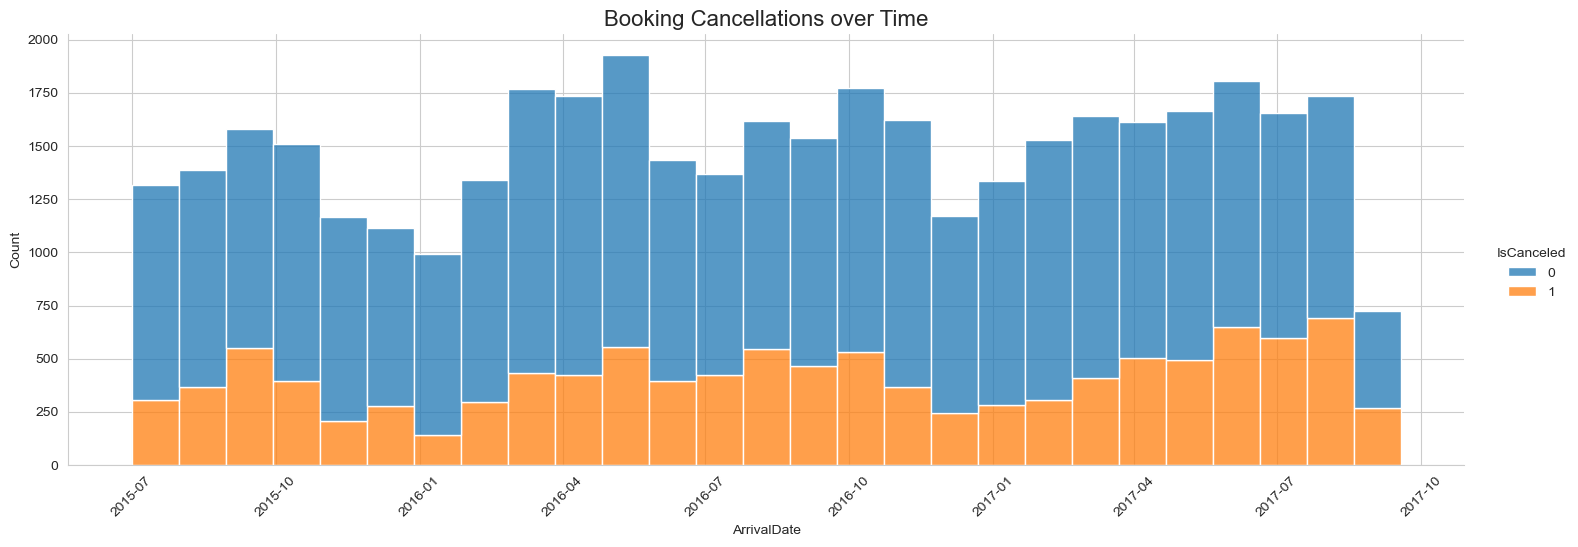

In [618]:
sns.displot(x='ArrivalDate', hue='IsCanceled', data=df, binwidth=30, multiple='stack', aspect=3, height=5)
plt.title('Booking Cancellations over Time', fontsize=16)
plt.xticks(rotation=45)
plt.show()

#### Insights
* The summer months are the most popular months for booking. The average daily rate is also higher during the summer months.
* There doesn't seem to be an increase in cancellations during the summer months, implying that there is no relationship between ADR and the rate of cancellation.

### Is Lead Time a good predictor of cancellations?

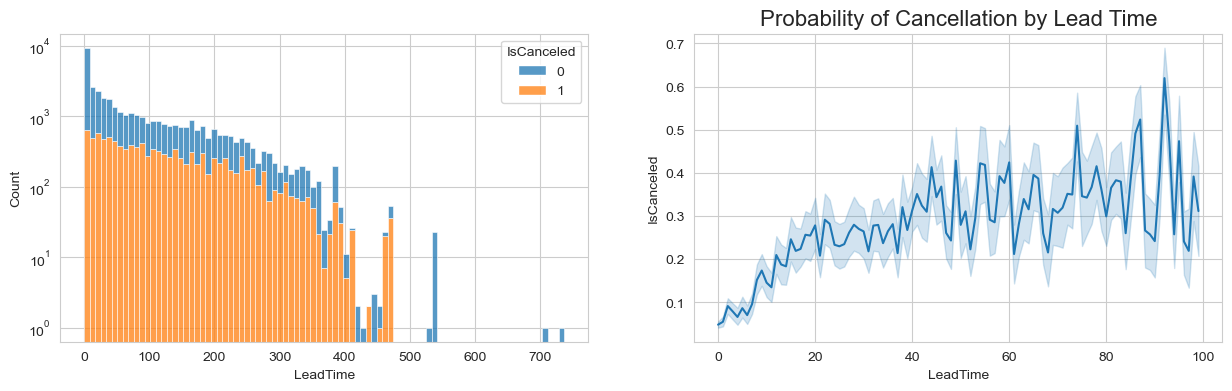

In [619]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df, x='LeadTime', hue='IsCanceled', ax=ax[0], multiple='stack', log_scale=(False, True))
sns.lineplot(data=df[df['LeadTime'] < 100], x='LeadTime', y='IsCanceled', ax=ax[1])
plt.title('Probability of Cancellation by Lead Time', fontsize=16)
plt.show()

#### Insights
* There is a clear relationship between lead time and cancellations. 
* The longer the lead time, the more likely the booking is to be canceled. 
* The probability of cancellation is around 25% after 18 days.
* This probability increases to 50% after 40 days.
* After 40 days, the probability of cancellation is all over the place.

### Which market segments are the most important ones?

There are a few variables that describe the market segment. Let's see how they affect the cancellation rate.

<AxesSubplot: xlabel='CustomerType', ylabel='count'>

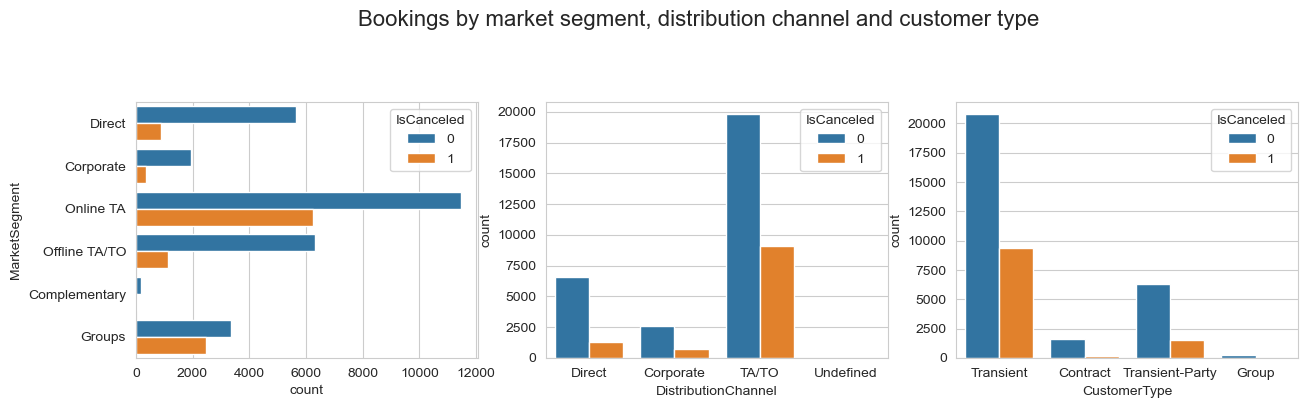

In [620]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Bookings by market segment, distribution channel and customer type', fontsize=16)
plt.subplots_adjust(top=0.75)
stat = 'percent'
sns.countplot(y='MarketSegment', hue='IsCanceled', data=df, ax=ax[0])   
sns.countplot(x='DistributionChannel', hue='IsCanceled', data=df, ax=ax[1])
sns.countplot(x='CustomerType', hue='IsCanceled', data=df, ax=ax[2])

#### Insights
 
* Transient customers and related bookings are the most prevalent.
* Bookings for customers in the Transient customer's party are less likely to cancel compared to the transient customer. 
* Bookings acquired by contract are far less likely to cancel. 
* Most bookings come from Travel Agents (TA) and Travel Operators (TO), followed by direct bookings.
* **Online** Travel Agents (TA) have a much higher rate of cancellation when compared to **Offline** travel agents.

##### Travel agents bring in a lot of business, but Direct bookings and those made by Offline travel agents and Corporate client are more desirable.

# Data Preparation

In [621]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40060 entries, 0 to 40059
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   IsCanceled                   40060 non-null  int64         
 1   LeadTime                     40060 non-null  int64         
 2   ArrivalDateYear              40060 non-null  int64         
 3   ArrivalDateMonth             40060 non-null  object        
 4   ArrivalDateWeekNumber        40060 non-null  int64         
 5   ArrivalDateDayOfMonth        40060 non-null  int64         
 6   StaysInWeekendNights         40060 non-null  int64         
 7   StaysInWeekNights            40060 non-null  int64         
 8   Adults                       40060 non-null  int64         
 9   Children                     40060 non-null  int64         
 10  Babies                       40060 non-null  int64         
 11  Meal                         40060 non-nu

In [622]:
# Strip whitespace from all the columns of type Object
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

## IsCanceled

This is our target variable it is a binary variable. Let's see the distribution of this variable. There are many more bookings that are not canceled than canceled, making this a rather unbalanced dataset

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

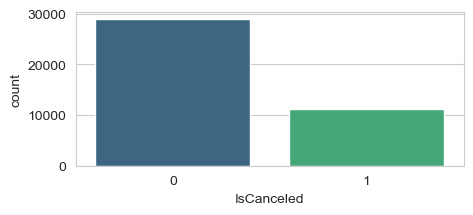

In [623]:
# plot the distribution of IsCanceled, which is a binary variable
plt.figure(figsize=(5, 2))
sns.countplot(x='IsCanceled', data=df, palette='viridis')
plt.xticks(rotation=0)

## Stay-in-night variables

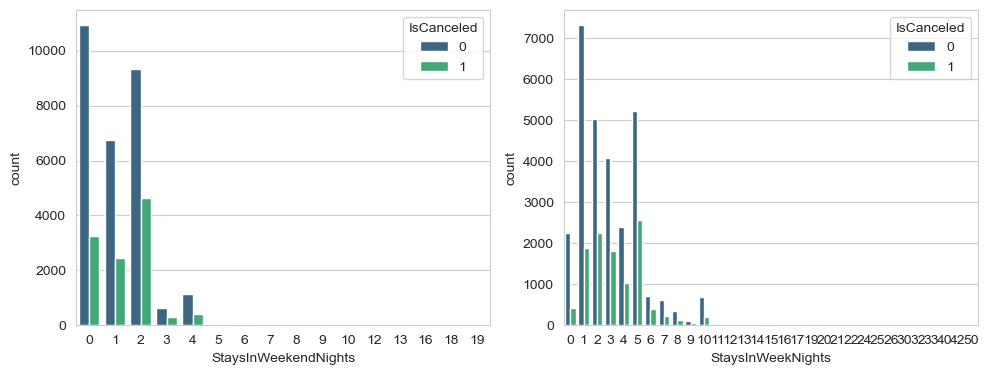

In [624]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(top=0.75)
fig.suptitle('', fontsize=16)
sns.countplot(x='StaysInWeekendNights', hue='IsCanceled', data=df, palette='viridis', ax=axs[0])
sns.countplot(x='StaysInWeekNights', hue='IsCanceled', data=df, palette='viridis', ax=axs[1])
plt.tight_layout()
plt.show()

In [625]:
print(f'Number of rows with StaysInWeekNights = 0: {df[df["StaysInWeekNights"] > 14].shape[0]}')
print(f'Number of rows with StaysInWeekendNights = 0: {df[df["StaysInWeekendNights"] > 7].shape[0]}')

Number of rows with StaysInWeekNights = 0: 170
Number of rows with StaysInWeekendNights = 0: 57


There are some 0s in the stay in night variables, but this is not an error. It means that the customer booked the hotel but did not stay overnight. Let's see how many of these bookings were canceled. There are some outliers in the data as well, so we will consider only rows where `StaysInWeekNights` is over 2 weeks, and `StaysInWeekendNights` is over 1 week.

In [626]:
# remove rows from the dataframe 'df' where StaysInWeekNights i greater than 10
df.drop(df[(df['StaysInWeekNights'] > 14) | (df['StaysInWeekendNights'] > 7)].index, inplace=True)

## Adults, Children and Babies

Only 'Children' has an outlier row with 10 children. Let's remove it.

In [627]:
df.drop(df[df["Children"] == 10].index, inplace=True)

## Meal

According to the field description, the values 'Undefined' and 'SC' are the same. Let's replace 'Undefined' with 'SC'. 

In [628]:
# Looks like the category names have empty spaces, strip them.
df['Meal'] = df['Meal'].str.strip()
df['Meal'].replace('Undefined', 'SC', inplace=True)
df['Meal'].value_counts()

BB    29934
HB     7956
SC     1245
FB      754
Name: Meal, dtype: int64

## Market Segment, and Distribution Channel.

In [629]:
# Remove the rows where MarketSegment is 'Complementary', only a few of them exist
df['MarketSegment'] = df['MarketSegment'].str.strip()
df.drop(df[df['MarketSegment'] == 'Complementary'].index, inplace=True)

In [630]:
# Remove the rows where DistributionChannel is 'Undefined'.
df['DistributionChannel'] = df['DistributionChannel'].str.strip()
df.drop(df[df['DistributionChannel'] == 'Undefined'].index, inplace=True)

## PreviousBookingsNotCanceled and PreviousCancellations

There are some outliers in these columns. Let's remove them.

In [631]:
outlier_count = df[df['PreviousCancellations'] >= 4].shape[0]
df.drop(df[df['PreviousCancellations'] >= 4].index, inplace=True)
print(f'Removed {outlier_count} rows from PreviousCancellations')

outlier_count = df[df['PreviousBookingsNotCanceled'] >= 12].shape[0]
df.drop(df[df['PreviousBookingsNotCanceled'] >= 12].index, inplace=True)
print(f'Removed {outlier_count} rows from PreviousBookingsNotCanceled')

Removed 141 rows from PreviousCancellations
Removed 63 rows from PreviousBookingsNotCanceled


## Agent and Company

These two variables contain NULL values. This means that the booking was not made through a travel agent or a company. Let's engineer a couple of new feature called `IsAgent` and `IsCompany` to indicate whether the booking was made through a travel agent or a company. 

In [632]:
df['IsAgent'] = df['Agent'].apply(lambda x: 1 if x != 'NULL' else 0)
df['IsCompany'] = df['Company'].apply(lambda x: 1 if x != 'NULL' else 0)
df = df.drop(columns=['Agent', 'Company'])

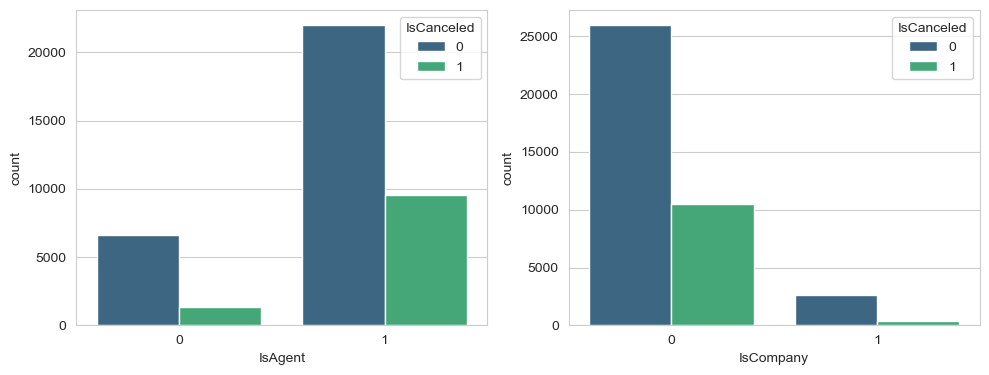

In [633]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(top=0.75)
fig.suptitle('', fontsize=16)
sns.countplot(x='IsAgent', hue='IsCanceled', data=df, palette='viridis', ax=axs[0])
sns.countplot(x='IsCompany', hue='IsCanceled', data=df, palette='viridis', ax=axs[1])
plt.tight_layout()
plt.show()

## ADR

This is the **average daily rate** as defined by dividing the sum of all lodging transactions by the total number of staying nights.

In [634]:
df['ADR'].describe()

count    39484.000000
mean        95.764708
std         61.354571
min         -6.380000
25%         50.967500
50%         76.000000
75%        126.000000
max        508.000000
Name: ADR, dtype: float64

There are some rows with ADR below 10. Let's remove them

In [635]:
# Remove all the rows for which ADR is below 1
df = df[df['ADR'] > 10]
# How many booking with invalid ADR?
print(f'Number of rows removed with ADR below $10: {df[df["ADR"] < 10].shape[0]}')

Number of rows removed with ADR below $10: 0


Text(0.5, 0, 'ADR in $')

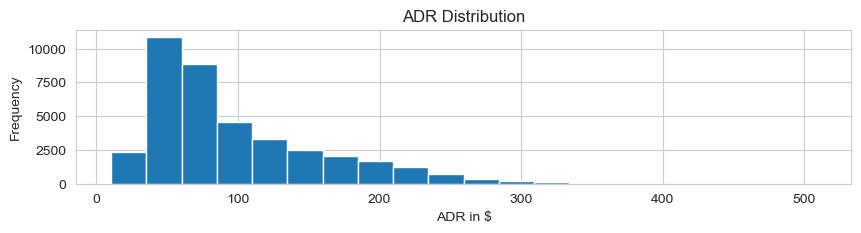

In [636]:
plt.figure(figsize=(10, 2))
df['ADR'].plot(kind='hist', bins=20, title='ADR Distribution')
ax = plt.gca()
ax.set_xlabel('ADR in $')

## Drop the columns that we don't need

In [637]:
df.drop(columns=['ReservationStatus', 'ReservationStatusDate', 'ArrivalDate', 'BookingDate'], inplace=True)

In [638]:
# Save the cleaned data to a new file
df.to_csv('../data/cleaned_data.csv', index=False)
# Reload the data
df = pd.read_csv('../data/cleaned_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38789 entries, 0 to 38788
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   38789 non-null  int64  
 1   LeadTime                     38789 non-null  int64  
 2   ArrivalDateYear              38789 non-null  int64  
 3   ArrivalDateMonth             38789 non-null  object 
 4   ArrivalDateWeekNumber        38789 non-null  int64  
 5   ArrivalDateDayOfMonth        38789 non-null  int64  
 6   StaysInWeekendNights         38789 non-null  int64  
 7   StaysInWeekNights            38789 non-null  int64  
 8   Adults                       38789 non-null  int64  
 9   Children                     38789 non-null  int64  
 10  Babies                       38789 non-null  int64  
 11  Meal                         38789 non-null  object 
 12  Country                      38353 non-null  object 
 13  MarketSegment   

# Preprocessing

## Scale and Transform

* Numerical columns are scaled using StandardScaler
* Numerical columns don't need imputation because there are no missing values.
* Categorical columns are encoded using OneHotEncoder.

In [639]:
numeric_selector = make_column_selector(dtype_include=['int64', 'float64'])
category_selector = make_column_selector(dtype_include='object')

# Put together the column transformer
transformer = make_column_transformer(
    (StandardScaler(), numeric_selector),
    (OneHotEncoder(drop = 'if_binary'), category_selector),
)

transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28a93a980>),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28df0f7f0>)])

## Split the data

In [640]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['IsCanceled'], axis = 1), 
    df['IsCanceled'], 
    random_state = 442, 
    stratify = df['IsCanceled']
)

# Modeling

We will continue this work in the following COLAB notebook: [Model Building and Analysis](https://colab.research.google.com/drive/15ZaPohqmvR2tk3uvB2OW6NwEVyM9blpW?usp=sharing)